#  CHE 614 course project milestone 3: Heat transfer behavior modeling in core-shell paraffin@Silica nanoparticles with Openpnm.

## Jinhe Zhang #20985826

A core-shell structure material (paraffin@silica) model will be built in this project. This material contains a solid silica shell, a pore struction which willl filled with paraffin. Since the core material, paraffin wax, is a well-known phase change material, it has different states at different temperatures (which can be understood as different heat transfer properties). This also leads to the study of the heat transfer properties of this material being more complex. My project will use Openpnm to model this material and study its heat transfer behavior. Simulations of phase transitions are currently based on varying the heat transfer coefficient. The specific process is described below.
## 1. Generating network
First build a core-shell structure model. Investigate heat transfer models within spatial networks. A cubic network will be built. Import the usual packages and instantiate a 3D cubic network for demonstration prupose:

In [8]:
import numpy as np
import openpnm as op
import scipy as sp
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
shape = [10, 10, 10]
spacing = 1e-5
net = op.network.Cubic(shape=shape, spacing=spacing)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-08-23 19:24:45,172
------------------------------------------------------------


## 2. Adding geometry
The paraffin-based core-shell phase change materials prepared in the existing literature tend to have oxide shell thicknesses of similar size and paraffin core diameters of different sizes.(can be seen in the following figures) In my project, the diameter of the holes representing the core is set to be randomly distributed, and the thickness of the shell is set to a fixed value. Use model from library to set wach throat diameter equals to its smallest neighbor pore.

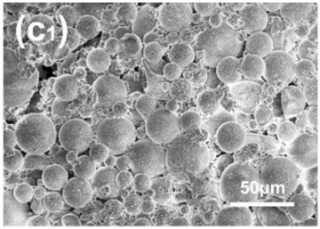
Energy, 2018, 158, 1052-1059

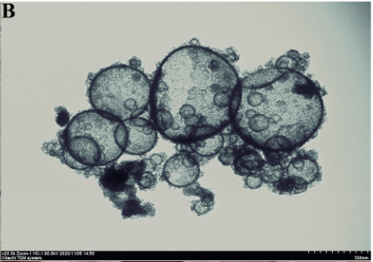
Colloids and Surfaces A: Physicochemical and Engineering Aspects 625 (2021) 126905


In [10]:
geom = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)
geom['pore.diameter'] = np.random.rand(net.Np)*1e-5
mode = op.models.misc.from_neighbor_pores
geom['throat.diameter'] = mode(target=geom, prop='pore.diameter')

## 3. Adding phases
Assume that phases in the model mainly including paraffin, silica and air. Since the paraffin is considered to be a phase change material. The therml conductivity can be changed by the state of the phase (solid paraffin or liquid paraffin). Conductivity for solid paraffin is 0.4 W/mK, and for liquid paraffin is 0.2 W/mK. The phase change temperature of paraffin is assumed to be 50℃ (323K).

In [11]:
#bulk = op.phases.GenericPhase(network=net)
prf = op.phases.GenericPhase(network=net)
air = op.phases.Air(network=net)

## 4. Adding physics
Set a custom phase for the bulk (core-shell nanoparticle) phase, next step is to find the heat transfer conductance.

In [12]:
phys = op.physics.GenericPhysics(network=net, phase=prf, geometry=geom)

In order to facilitate variable adjustment, the parameters to be changed are set in advance.

In [13]:
inlet = net.pores('left')            # set the inlet
outlet = net.pores('right')       # set the outlet
Rs = 1e-6                                # silica layer thickness
T_in = 333                               # K, inlet temperature
T_out = 313                             # K, outlet temperature
T_melting = 323                      # K, paraffin melting temperature

Paraffin is a phase change material with different heat transfer coefficients in liquid and solid state. However, since the temperature distribution inside the grid is currently unknown, so the state of the paraffin cannot be determined. Therefore, it is necessary to obtain the preliminary temperature distribution in the grids. My method is: assuming that all the paraffin inside the material is in a solid state (the heat transfer coefficient is 0.4 W/mK), then calculate the temperature distribution.

In [16]:
Ka = air['pore.thermal_conductivity']   # air heat transfercoefficient
Kps = 0.4
Kpl = 0.2
Ks = 0.27

In [17]:
P12 = net['throat.conns']
D1 = geom['pore.diameter'][P12[:,0]]    # diameter of one pore/ paraffin core
D2 = geom['pore.diameter'][P12[:,1]]    # diameter of another pore/ paraffin core
R_T = geom['throat.diameter']/2           # radius of throat/ heat transfer channel
R_P = geom['pore.diameter']/2             # radius of pore/ paraffin core
R_w = spacing - D1/2 - D2/2                 # the R_w means the distance between two paraffin sphere surfaces

In [18]:
def gfunc(T, Kp):
        g_P = Kp*sp.pi*(R_P)**2/(R_P)
        g_th = np.zeros_like(R_T)              
        for i in range(len(R_w)):
            if R_w[i] - 2 * Rs > 0:            
                R_sas = R_w - 2*Rs             
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(Rs)
                g_A = np.mean(Ka)*sp.pi*(R_T[i])**2/(R_sas[i])
                g_th[i] = (1/g_A + 2/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
            else:                              
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(R_w[i])
                g_th[i] = (1/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
        return g_th

The heat transfer process between the two core-shell nanospheres can be obtained by calculating the total thermal conductance. If the two spheres are touching each other, their heat transfer conductance can be regarded as consisting of two radii of paraffin and middle silica layer, a total of three parts. Another situation is that the two spheres are not in contact, so the heat transfer conductance between them can be regarded as two radii of paraffin, two silca shell layers and the air in the middle, a total of five parts.（as shown in following figures）

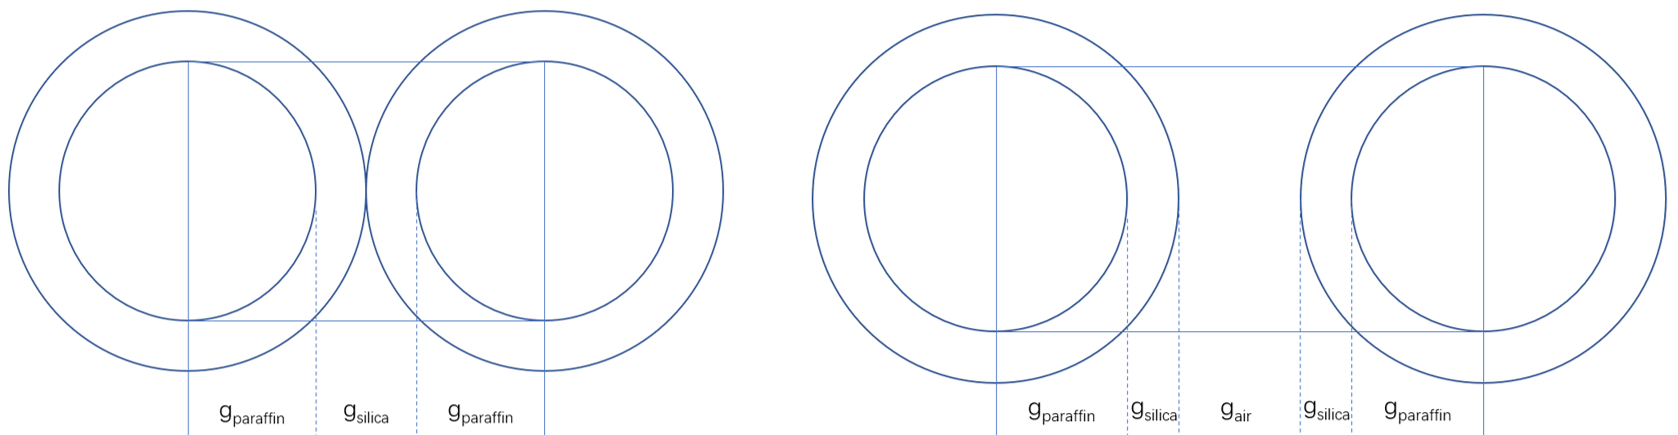

In [19]:
phys['throat.thermal_conductance'] = gfunc(T=313.0, Kp=0.4)

## 5. Performing fourier conduction
The first step of this performing is to obtain a temperature distribution of the grid. 

In [20]:
fc = op.algorithms.FourierConduction(network=net)
fc.setup(phase=bulk)
fc.set_value_BC(pores=inlet, values=T_in)
fc.set_value_BC(pores=outlet, values=T_out)
fc.run()
print(fc['pore.temperature'])

[333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         

The state of paraffin can be judged by the temperature distribution. The paraffin with temperature higher than 323K is regarded as liquid, and the temperature less than or equal to 323K is solid.

In [33]:
num = 5                                     # times of restart
for x in range(num):
    T_p = fc['pore.temperature']
    K_prf = np.zeros_like(R_P)
    for i in range(len(T_p)):
        if T_p[i] > T_melting:
            K_prf[i] = Kpl
        else:
            K_prf[i] = Kps
    prf['pore.thermal_conductivity'] = K_prf
    phys['throat.thermal_conductance'] = gfunc(T = T_p, Kp=K_prf)
    fc = op.algorithms.FourierConduction(network=net)
    fc.setup(phase=prf)
    fc.set_value_BC(pores=inlet, values=T_in)
    fc.set_value_BC(pores=outlet, values=T_out)
    fc.run()

In [34]:
print(fc['pore.temperature'])

[333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         333.         333.         333.         333.
 333.         

A relatively correct paraffin state distribution is obtained, and the above calculation process is repeated to obtain a modified temperature distribution.

Now, we have a much more reliable temperature profile. Further, we can count the temperature distribution.

(array([200., 101., 123.,  96.,  66.,  67.,  60.,  67.,  54., 166.]),
 array([313., 315., 317., 319., 321., 323., 325., 327., 329., 331., 333.]),
 <BarContainer object of 10 artists>)

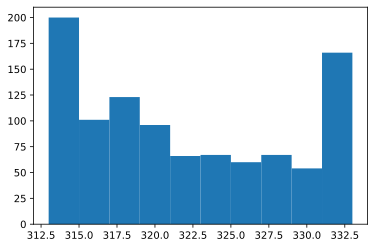

In [35]:
plt.hist(fc['pore.temperature'])

After modifying the paraffin state, the temperature distribution can also be trusted, which is the calculation result including the phase transition.

## 6.Calculate the effective heat transfer coefficient.
Calculate Effective Thermal Conductivity Using Fourier's Law.

$$k_{eff}=\frac{q \cdot A}{L \cdot \Delta T} $$

In [36]:
rate_inlet = fc.rate(pores=inlet)[0]
print(f'Heat flow rate from inlet: {rate_inlet:.5e} W')

Heat flow rate from inlet: 3.08903e-05 W


In [37]:
A = (shape[0] * shape[1])*(spacing**2)
L = shape[2]*spacing
k_eff = rate_inlet * L / (A * (T_in - T_out))
print("{0:.6E}".format(k_eff))

1.544514E-02


## 7. Visualization
Drawing with matplotlib

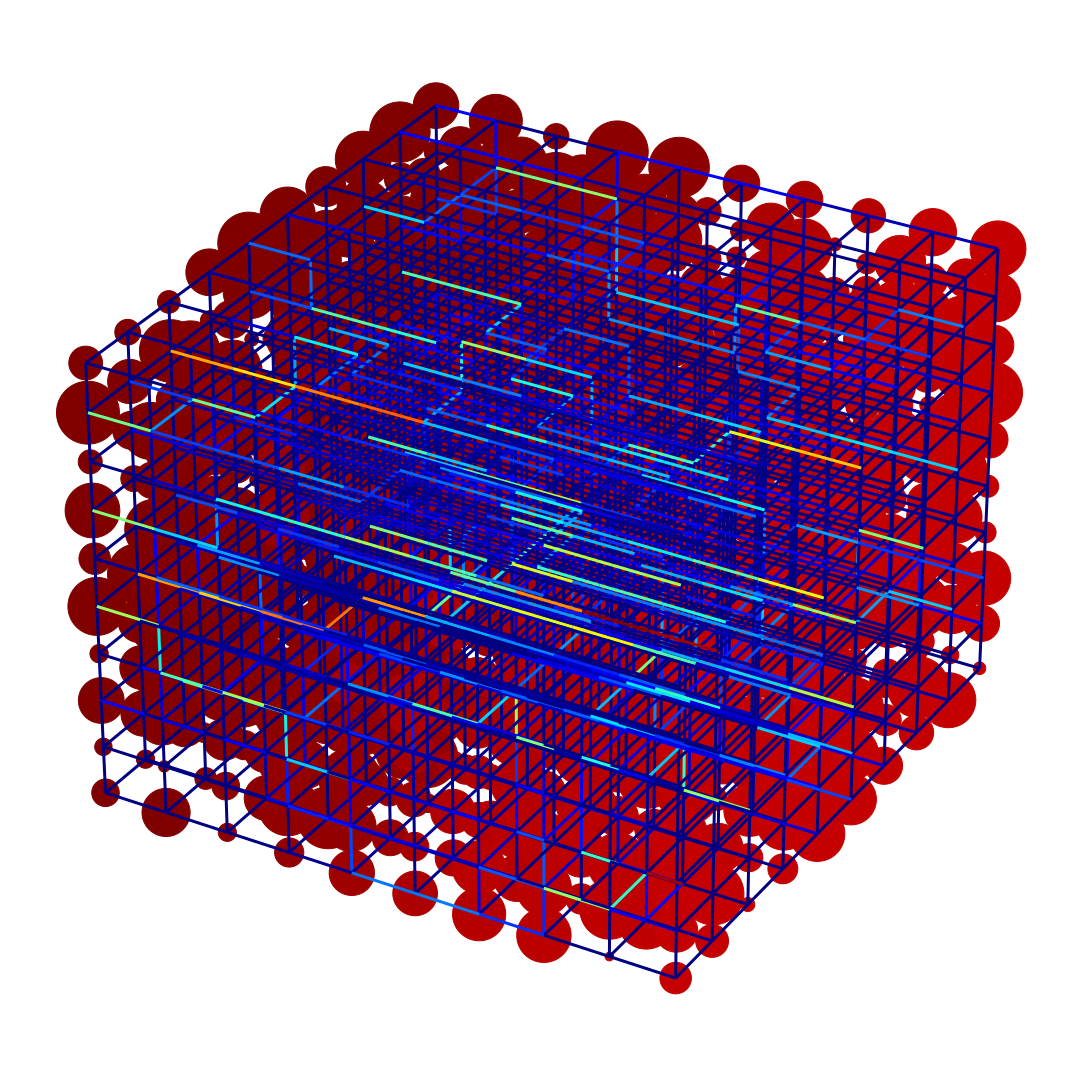

In [130]:
t = fc['pore.temperature']
r = fc.rate(throats=net.Ts, mode='single')
d = net['pore.diameter']
fig, ax = plt.subplots(figsize=[30,15])
op.topotools.plot_coordinates(network=net, color_by=t, size_by=d, markersize=4000, ax=ax)
op.topotools.plot_connections(network=net, color_by=r, linewidth=3, ax=ax)
_ = plt.axis('off')

Or use paraview for visualization

In [18]:
net.project.export_data(phases=[fc], filename='60_40_ls_prf', filetype='vtk')

------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-07-29 15:27:46,781
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-07-29 15:27:46,782
------------------------------------------------------------


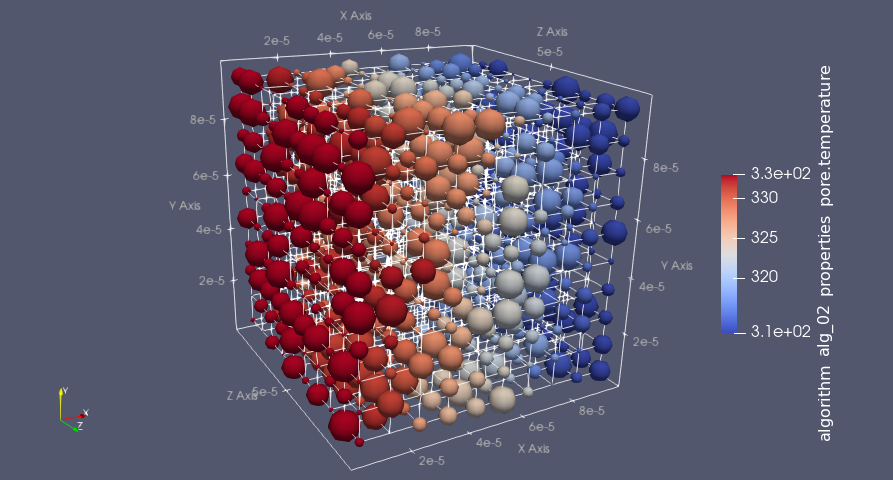

## 8. Sensitivity analysis
By adjusting different thickness of silica, a series of effective heat transfer coeffiicient can be calculated by this moedle.

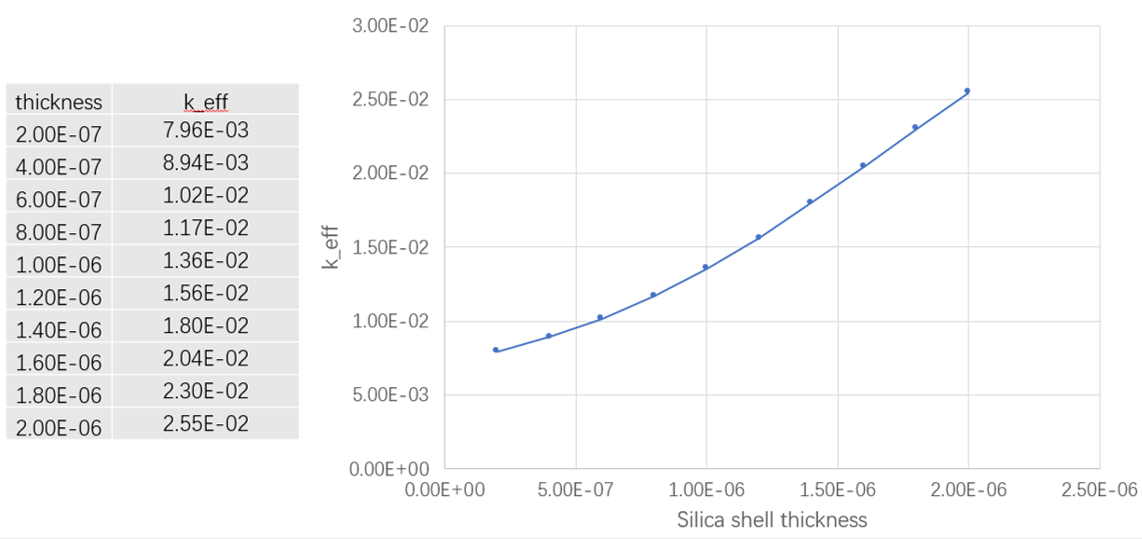